In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import datetime

%load_ext tensorboard

In [2]:
# Clear any logs from previous runs
# rm -rf ./data/logs/

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/Train",
    seed = 123,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 383 files belonging to 4 classes.


In [5]:
class_names = dataset.class_names
class_names

['Blotch_Apple', 'Normal_Apple', 'Rot_Apple', 'Scab_Apple']

In [6]:
# len(dataset)

In [7]:
testset = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/Test",
    seed = 123,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 120 files belonging to 4 classes.


In [8]:
class_names = testset.class_names
class_names

['Blotch_Apple', 'Normal_Apple', 'Rot_Apple', 'Scab_Apple']

In [9]:
# len(testset)

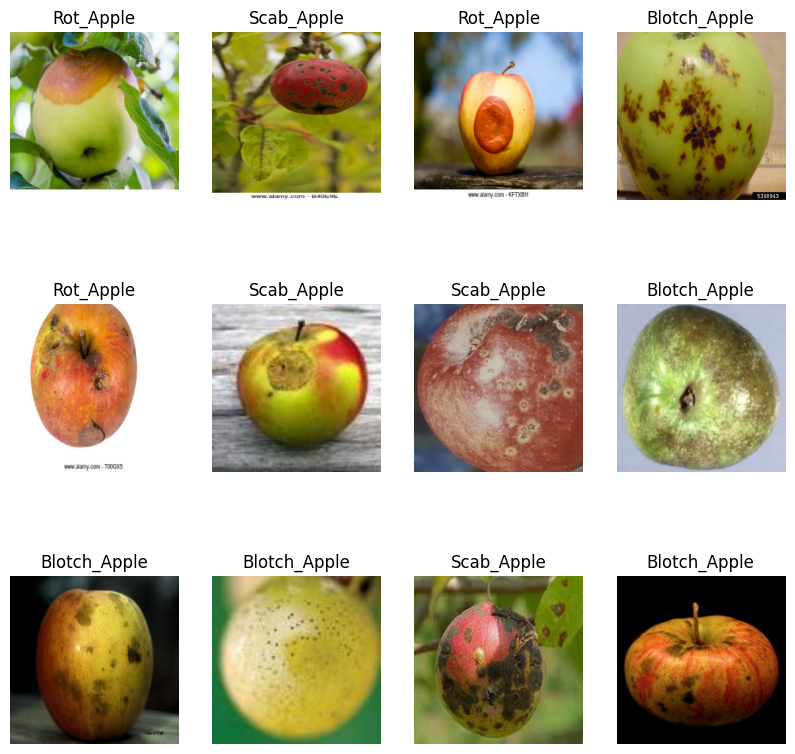

In [10]:
plt.figure(figsize=(10, 10)) # om dimensies totale afbeelding aan te passen en tekst leesbaar te houden
for image_batch, label_batch in dataset.take(1): # toont at random afbeeldingen uit de dataset
    # print(image_batch.shape)
    # print(label_batch.numpy())
    # print(image_batch[0].numpy)
    # print(image_batch[0].shape)
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)    
        # plt.imshow(image_batch[0].numpy().astype("uint8"))
        # plt.title(class_names[label_batch[0]])
        plt.imshow(image_batch[i].numpy().astype("uint8")) # met [i] ipv [0] wordt de loop doorlopen en 12 afb. getoond
        plt.title(class_names[label_batch[i]])
        plt.axis("off") # om extra informatie (> assen) uit te zetten

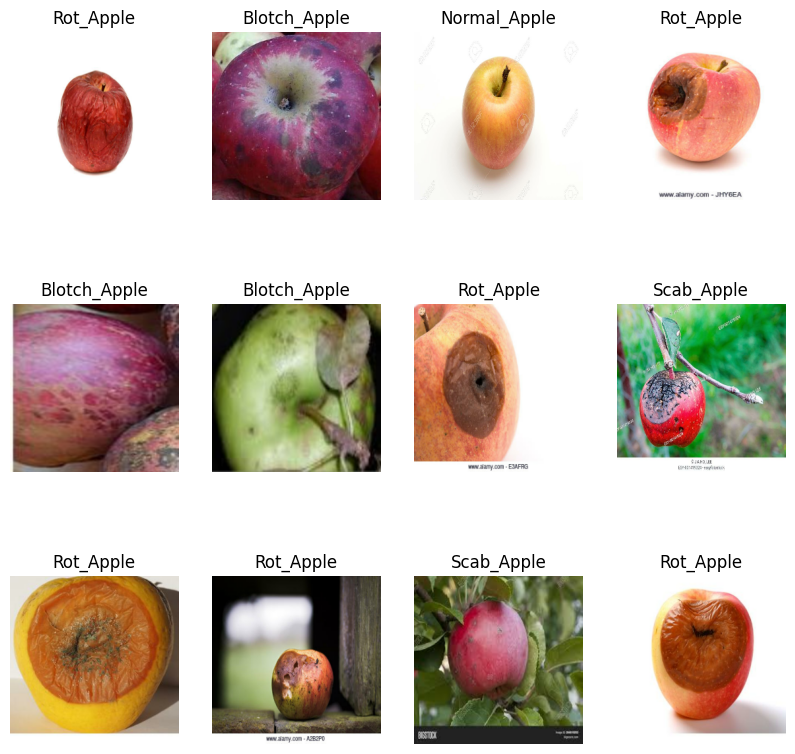

In [11]:
plt.figure(figsize=(10, 10)) # om dimensies totale afbeelding aan te passen en tekst leesbaar te houden
for image_batch, label_batch in testset.take(1): # toont at random afbeeldingen uit de dataset
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)    
        plt.imshow(image_batch[i].numpy().astype("uint8")) 
        plt.title(class_names[label_batch[i]])
        plt.axis("off") 

In [12]:
train_size = 0.8
len(dataset)*train_size

9.600000000000001

In [13]:
train_ds = dataset.take(9) # met .take() worden de eerste (x) batches geslecteerd
len(train_ds)

9

In [14]:
# test_ds = dataset.skip() # met .skip() worden er overgeslagen
# omdat we een aparte folder voor de test-dataset hebben, kunnen we deze als onderstaand inladen
test_ds = testset
len(test_ds) # lengte in batches

4

In [15]:
val_size = 0.2
len(dataset)*val_size

2.4000000000000004

In [16]:
val_ds = dataset.skip(9)
len(val_ds)

3

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.2, shuffle=True, shuffle_size=10000):

    assert (train_split + val_split) == 1 # test_split niet want extra folder

    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    # test_ds = ds.skip(train_size).skip(val_size) # als we de test-dataset ook uit dezelfde batch/folder zouden halen
    test_ds = testset
        
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
# len(train_ds)

In [20]:
# len(val_ds)

In [21]:
# len(test_ds)

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) ## bij CPU én GPU gebruik.
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)    
])

In [24]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

Apply data augmentation to train dataset

In [25]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
tf.keras.layers.BatchNormalization(
    axis=-1,
    momentum=0.99,
    epsilon=0.001,
    center=True,
    scale=True,
    beta_initializer='zeros',
    gamma_initializer='ones',
    moving_mean_initializer='zeros',
    moving_variance_initializer='ones',
    beta_regularizer=None,
    gamma_regularizer=None,
    beta_constraint=None,
    gamma_constraint=None,
)

# minus **kwargs

In [27]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    # tf.keras.layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),   
    layers.Dropout(0.2), 
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(258, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')          
])

model.build(input_shape=input_shape)

In [28]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [29]:
# model.summary()

In [30]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [31]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    callbacks = [tensorboard_callback]
)

Epoch 1/20
9/9 [==============================] - 17s 459ms/step - loss: 1.3817 - accuracy: 0.2404 - val_loss: 1.3577 - val_accuracy: 0.3281
Epoch 2/20
9/9 [==============================] - 3s 319ms/step - loss: 1.3517 - accuracy: 0.3554 - val_loss: 1.3459 - val_accuracy: 0.3906
Epoch 3/20
9/9 [==============================] - 3s 276ms/step - loss: 1.3329 - accuracy: 0.3728 - val_loss: 1.3290 - val_accuracy: 0.3906
Epoch 4/20
9/9 [==============================] - 3s 283ms/step - loss: 1.2909 - accuracy: 0.4111 - val_loss: 1.2881 - val_accuracy: 0.4688
Epoch 5/20
9/9 [==============================] - 3s 275ms/step - loss: 1.2592 - accuracy: 0.4530 - val_loss: 1.2540 - val_accuracy: 0.4219
Epoch 6/20
9/9 [==============================] - 3s 284ms/step - loss: 1.2205 - accuracy: 0.4425 - val_loss: 1.2107 - val_accuracy: 0.4844
Epoch 7/20
9/9 [==============================] - 3s 276ms/step - loss: 1.1890 - accuracy: 0.4390 - val_loss: 1.1798 - val_accuracy: 0.4062
Epoch 8/20
9/9 [===

In [33]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 1s 218ms/step - loss: 1.0785 - accuracy: 0.5333


In [34]:
# scores

In [35]:
# history

In [36]:
# history.params

In [37]:
# history.history.keys()

In [38]:
# len(history.history['accuracy'])

In [39]:
# type(history.history['loss'])
# len(history.history['loss'])

In [40]:
# history.history['loss'][:5]# show loss for first 5 epochs

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

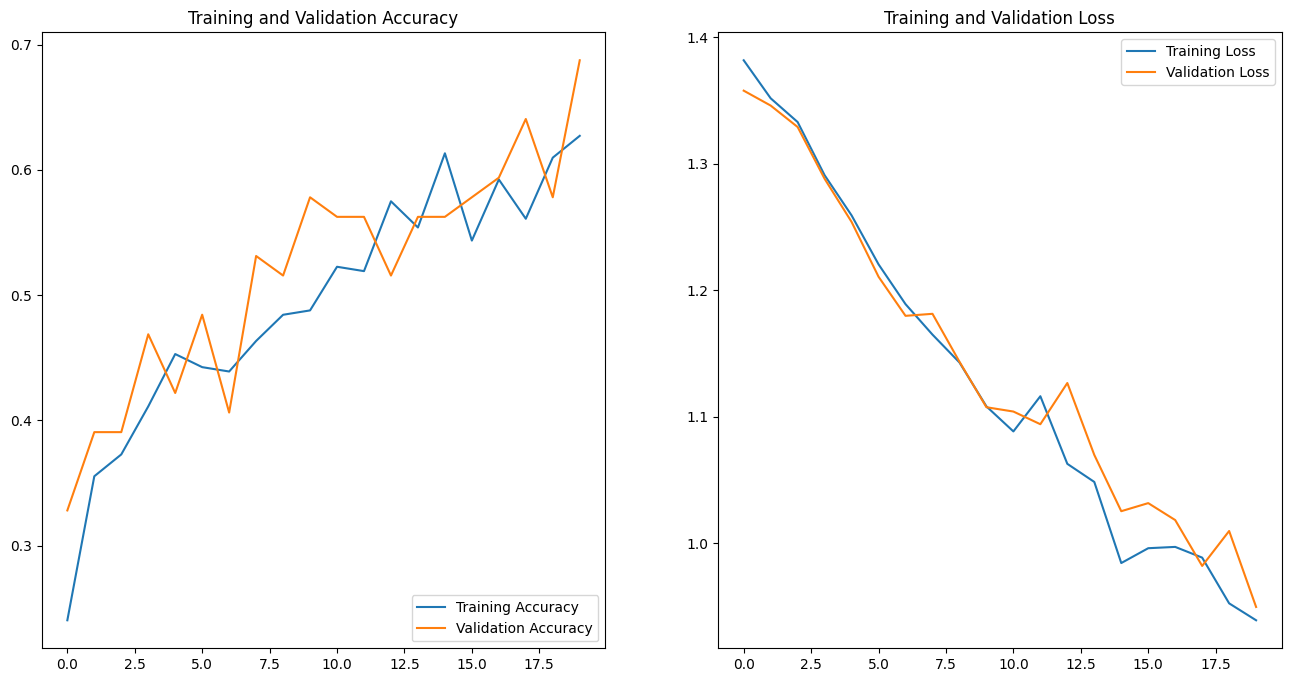

In [42]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

First image to predict
First image's actual label: Rot_Apple
Predicted label: Rot_Apple


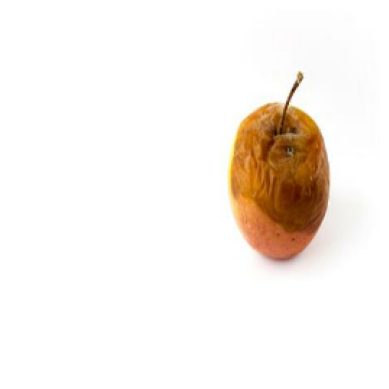

In [43]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    plt.axis("off")
    print("First image's actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted label:", class_names[np.argmax(batch_prediction[0])])
    # print(batch_prediction[0]) # input for np.argmax() above
    

In [44]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images_batch[i])
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
       
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence
                                  

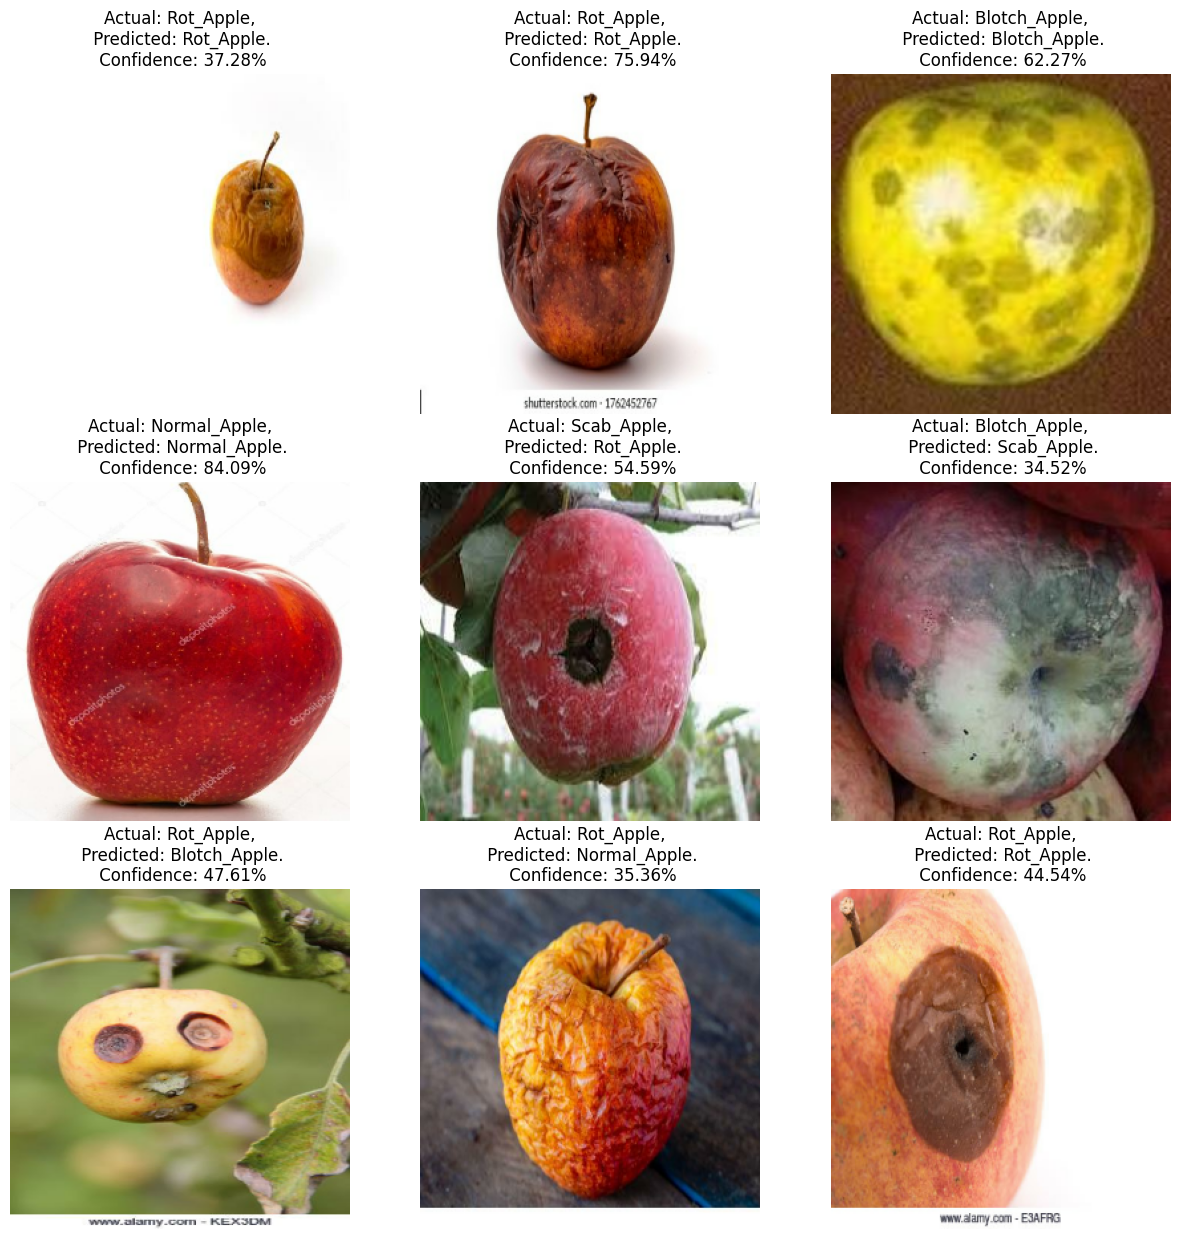

In [45]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy()) 
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [46]:
import os

model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/apple_disease_class_{model_version}") # check ValueError: invalid literal for int() with base 10: '.gitkeep' <<<

INFO:tensorflow:Assets written to: ../models/9\assets


In [47]:
model.save("..models/../apples.h5")

In [48]:
model.predict(test_ds)

array([[0.06010965, 0.6988181 , 0.10153742, 0.13953488],
       [0.25474796, 0.196169  , 0.29020047, 0.2588825 ],
       [0.45825645, 0.10246591, 0.14779077, 0.29148692],
       [0.05988237, 0.07254679, 0.83117384, 0.03639702],
       [0.3841473 , 0.10381073, 0.14140883, 0.37063318],
       [0.04919306, 0.7666315 , 0.02127276, 0.1629027 ],
       [0.45501405, 0.08290783, 0.10005205, 0.36202607],
       [0.524466  , 0.05892359, 0.21123286, 0.2053776 ],
       [0.40604404, 0.09640966, 0.1874841 , 0.31006226],
       [0.24137361, 0.1095966 , 0.4607227 , 0.18830708],
       [0.1349701 , 0.1927338 , 0.5423934 , 0.1299027 ],
       [0.5395928 , 0.07160223, 0.11453461, 0.27427033],
       [0.17957683, 0.32173032, 0.20037217, 0.29832065],
       [0.08960066, 0.08338009, 0.77266324, 0.05435594],
       [0.2389524 , 0.18646914, 0.07287293, 0.5017056 ],
       [0.44942966, 0.09078996, 0.17771618, 0.28206423],
       [0.2085523 , 0.20050861, 0.4427806 , 0.14815852],
       [0.4261858 , 0.11324899,

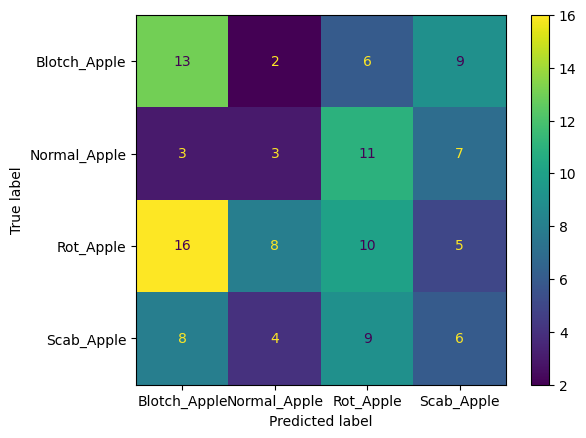

In [49]:
predictionBatch = model.predict(test_ds)
predictionEnhanced = tf.argmax(predictionBatch, axis=-1)
actualCategories = tf.concat([y for x, y in test_ds], axis=0)

confusionMatrix = metrics.confusion_matrix(actualCategories, predictionEnhanced)

cmDisplay = metrics.ConfusionMatrixDisplay(confusion_matrix = confusionMatrix, display_labels = ["Blotch_Apple", "Normal_Apple", "Rot_Apple", "Scab_Apple"])

cmDisplay.plot()

plt.show()

In [50]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 17836), started 23:35:41 ago. (Use '!kill 17836' to kill it.)